# The Image Classification Dataset
:label:`sec_fashion_mnist`

(~~The MNIST dataset is one of the widely used dataset for image classification, while it is too simple as a benchmark dataset. We will use the similar, but more complex Fashion-MNIST dataset ~~)

One widely used dataset for image classification is the  [MNIST dataset](https://en.wikipedia.org/wiki/MNIST_database) :cite:`LeCun.Bottou.Bengio.ea.1998` of handwritten digits. At the time of its release in the 1990s it posed a formidable challenge to most machine learning algorithms, consisting of 60,000 images of $28 \times 28$ pixels resolution (plus a test dataset of 10,000 images). To put things into perspective, back in 1995, a Sun SPARCStation 5 with a whopping 64MB of RAM and a blistering 5 MFLOPs was considered state of the art equipment for machine learning at AT&T Bell Laboratories. Achieving high accuracy on digit recognition was a key component in automating letter sorting for the USPS in the 1990s. Deep networks such as LeNet-5 :cite:`LeCun.Jackel.Bottou.ea.1995`, support vector machines with invariances :cite:`Scholkopf.Burges.Vapnik.1996`, and tangent distance classifiers :cite:`Simard.LeCun.Denker.ea.1998` all could reach error rates below 1%. 

For over a decade, MNIST served as *the* point of reference for comparing machine learning algorithms. 
While it had a good run as a benchmark dataset,
even simple models by today's standards achieve classification accuracy over 95%,
making it unsuitable for distinguishing between strong models and weaker ones. Even more, the dataset allows for *very* high levels of accuracy, not typically seen in many classification problems. This skewed algorithmic development towards specific families of algorithms that can take advantage of clean datasets, such as active set methods and boundary-seeking active set algorithms.
Today, MNIST serves as more of a sanity check than as a benchmark. ImageNet :cite:`Deng.Dong.Socher.ea.2009` poses a much 
more relevant challenge. Unfortunately, ImageNet is too large for many of the examples and illustrations in this book, as it would take too long to train to make the examples interactive. As a substitute we will focus our discussion in the coming sections on the qualitatively similar, but much smaller Fashion-MNIST
dataset :cite:`Xiao.Rasul.Vollgraf.2017` which was released in 2017. It contains images of 10 categories of clothing at $28 \times 28$ pixels resolution.


In [33]:
using Pkg
Pkg.activate("../../d2lai")
using d2lai, Flux, MLDatasets
using Images
using Plots

  Activating project at `/workspace/workspace/d2l-julia/d2lai`


## Loading the Dataset

Since the Fashion-MNIST dataset is so useful, all major frameworks provide preprocessed versions of it. We can  download and read it into memory using built-in framework utilities.


In [4]:
struct FashionMNISTData{T,V,L,A} <: AbstractData 
    train::T
    val::V
    labels::L
    args::A
    function FashionMNISTData(; batchsize = 64, resize = nothing)
        dataset = MLDatasets.FashionMNIST
        t = dataset(:train)[:]
        v = dataset(:test)[:]
        t = if isnothing(resize) 
            t 
        else
            features_resize = imresize(t.features, resize)
            (features = features_resize, targets = t.targets)
        end

        v = if isnothing(resize) 
            v 
        else
            features_resize = imresize(v.features, resize)
            (features = features_resize, targets = v.targets)
        end
        l = dataset().metadata["class_names"]
        args = (batchsize = batchsize,)
        new{typeof(t), typeof(v), typeof(l), typeof(args)}(t, v, l, args)
    end
end

Fashion-MNIST consists of images from 10 categories, each represented
by 6000 images in the training dataset and by 1000 in the test dataset.
A *test dataset* is used for evaluating model performance (it must not be used for training).
Consequently the training set and the test set
contain 60,000 and 10,000 images, respectively.

In [14]:
data = FashionMNISTData(; resize=(32, 32))
length(data.train.features), length(data.val.features)

(61440000, 10240000)

The categories of Fashion-MNIST have human-understandable names. 
The following convenience method converts between numeric labels and their names.

In [93]:
function text_labels(data::FashionMNISTData, indxs)
    getindex.(Ref(data.labels), indxs .+ 1)
end

text_labels (generic function with 2 methods)

## Reading a Minibatch

To make our life easier when reading from the training and test sets,
we use the built-in data iterator rather than creating one from scratch.
Recall that at each iteration, a data iterator

In [17]:
function d2lai.get_dataloader(data::FashionMNISTData; train = true, flatten = false)
    d = train ? data.train : data.val 
    if flatten 
        Flux.DataLoader((Flux.flatten(d[1]), d[2]); batchsize = data.args.batchsize, shuffle = train)
    else
        d_reshaped = reshape(d[1], size(d[1])[1], size(d[1])[2], 1, :)
        Flux.DataLoader((d_reshaped, d[2]); batchsize = data.args.batchsize, shuffle = train)
    end
end

To see how this works, let’s load a minibatch of images by invoking the train_dataloader method. It contains 64 images.



In [21]:
first(get_dataloader(data))[1] |> size

(32, 32, 1, 64)

Let’s look at the time it takes to read the images. Even though it is a built-in loader, it is not blazingly fast. Nonetheless, this is sufficient since processing images with a deep network takes quite a bit longer. Hence it is good enough that training a network will not be I/O constrained.



In [22]:
@time begin
    for (X, y) in train_dataloader(data)
        continue
    end
end

  0.496662 seconds (26.91 k allocations: 237.877 MiB, 77.00% gc time, 6.08% compilation time)


## Visualisations
We will often be using the Fashion-MNIST dataset. A convenience function show_images can be used to visualize the images and the associated labels. Skipping implementation details, we just show the interface below: we only need to know how to invoke d2lai.show_images rather than how it works for such utility functions.



In [73]:
function show_images(imgs, num_rows, num_cols, titles=nothing)
    
    plots = map(eachslice(imgs, dims = 4), 1:(num_rows*num_cols)) do img, i
        title = isnothing(titles) ? "" : titles[i]
        heatmap(dropdims(img, dims = 3), size = (100, 100), legend = false, xticks=false, yticks=false, title = title)
    end
    plot(plots..., layout = (1, 8), size = (1000, 100))
end

show_images (generic function with 2 methods)

Let’s put it to good use. In general, it is a good idea to visualize and inspect data that you are training on. Humans are very good at spotting oddities and because of that, visualization serves as an additional safeguard against mistakes and errors in the design of experiments. Here are the images and their corresponding labels (in text) for the first few examples in the training dataset.



In [90]:
function visualize(batch, nrows=1, ncols=8, labels=[])
    X, y = batch
    labels = text_labels(data, y)
    show_images(X, nrows, ncols, labels)
end

visualize (generic function with 5 methods)

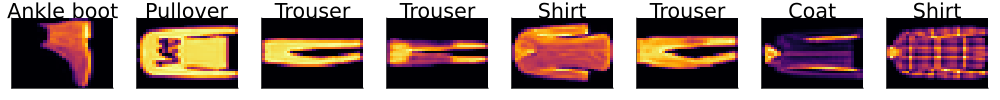

In [94]:
visualize(first(val_dataloader(data)))

We are now ready to work with the Fashion-MNIST dataset in the sections that follow.

## Summary

We now have a slightly more realistic dataset to use for classification. Fashion-MNIST is an apparel classification dataset consisting of images representing 10 categories. We will use this dataset in subsequent sections and chapters to evaluate various network designs, from a simple linear model to advanced residual networks. As we commonly do with images, we read them as a tensor of shape (batch size, number of channels, height, width). For now, we only have one channel as the images are grayscale (the visualization above uses a false color palette for improved visibility). 

Lastly, data iterators are a key component for efficient performance. For instance, we might use GPUs for efficient image decompression, video transcoding, or other preprocessing. Whenever possible, you should rely on well-implemented data iterators that exploit high-performance computing to avoid slowing down your training loop.


## Exercises

1. Does reducing the `batch_size` (for instance, to 1) affect the reading performance?
1. The data iterator performance is important. Do you think the current implementation is fast enough? Explore various options to improve it. Use a system profiler to find out where the bottlenecks are.
1. Check out the framework's online API documentation. Which other datasets are available?
